   5.341153335571289062e+01   2.142319869995116832e+01  \
0                105.698761                  23.734724   
1                 72.123802                  28.191591   
2                 63.261600                  30.987514   
3                 66.033516                  40.327370   
4                 49.423157                  43.179935   

    -9.197885888531144971e+00   -8.584693495962402210e+01  
0                   -6.131924                  -90.445878  
1                   -6.131924                  -81.247992  
2                   -4.598943                  -76.649049  
3                   -1.532981                  -62.852220  
4                   -3.065962                  -76.649049  


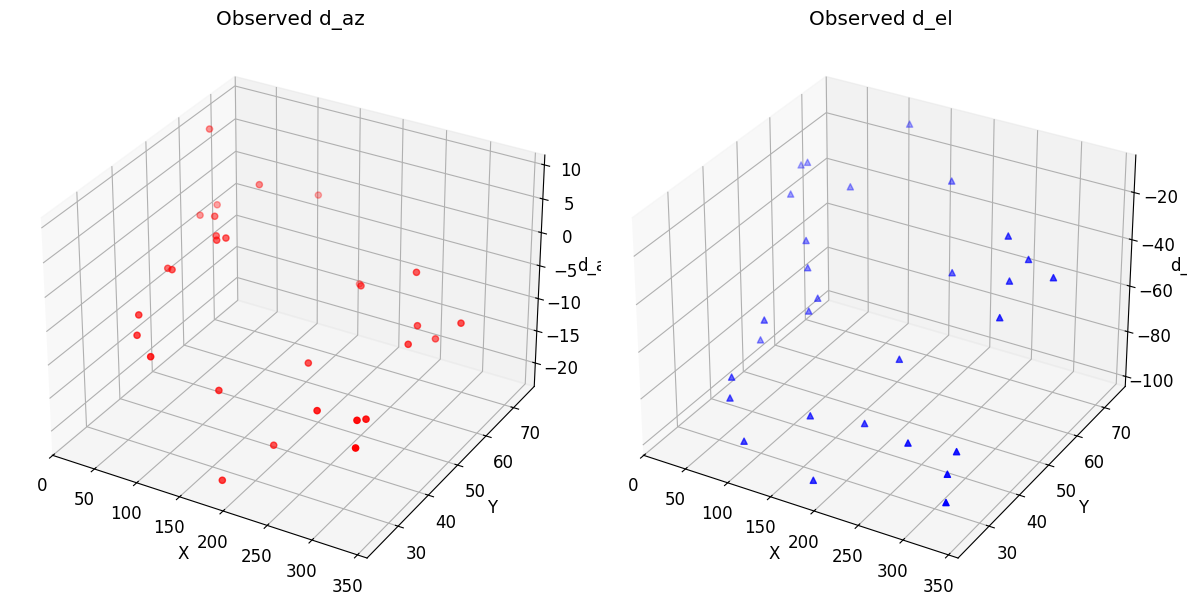

Fitted parameters for d_el: b1=3.2703391503905825, b2=-0.3554944075331059, b3=-134.47171710428444, g1=1.6760352827248162
Fitted parameters for d_az: a1=38.73235848987543, a2=-47.70011857053549, a3=20.83874030717266, b1=6.2468828451435785, b2=-4.628008051964397


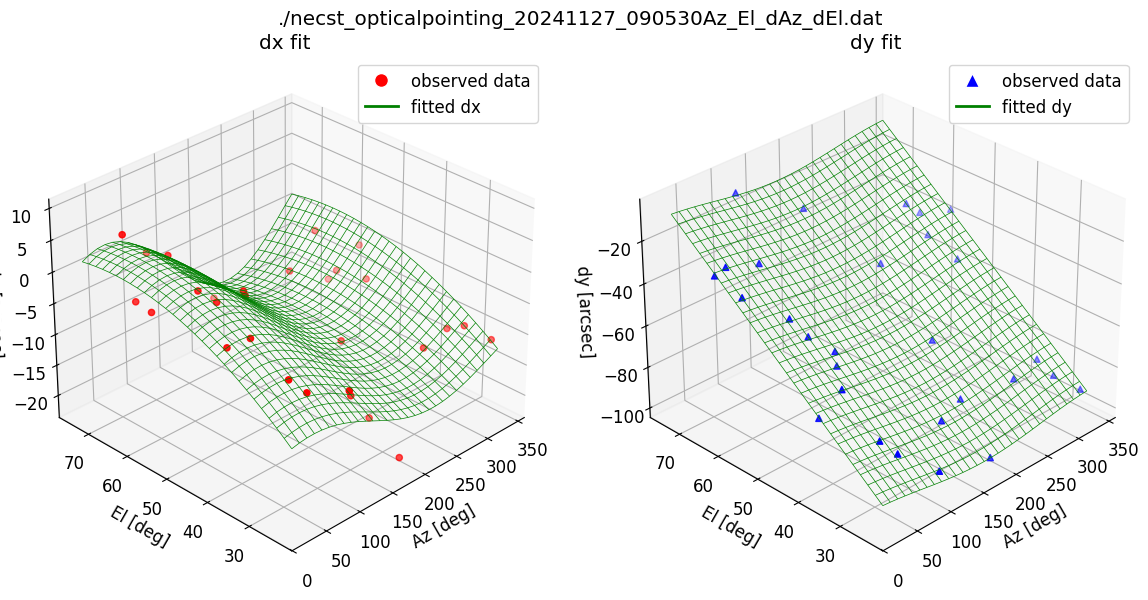

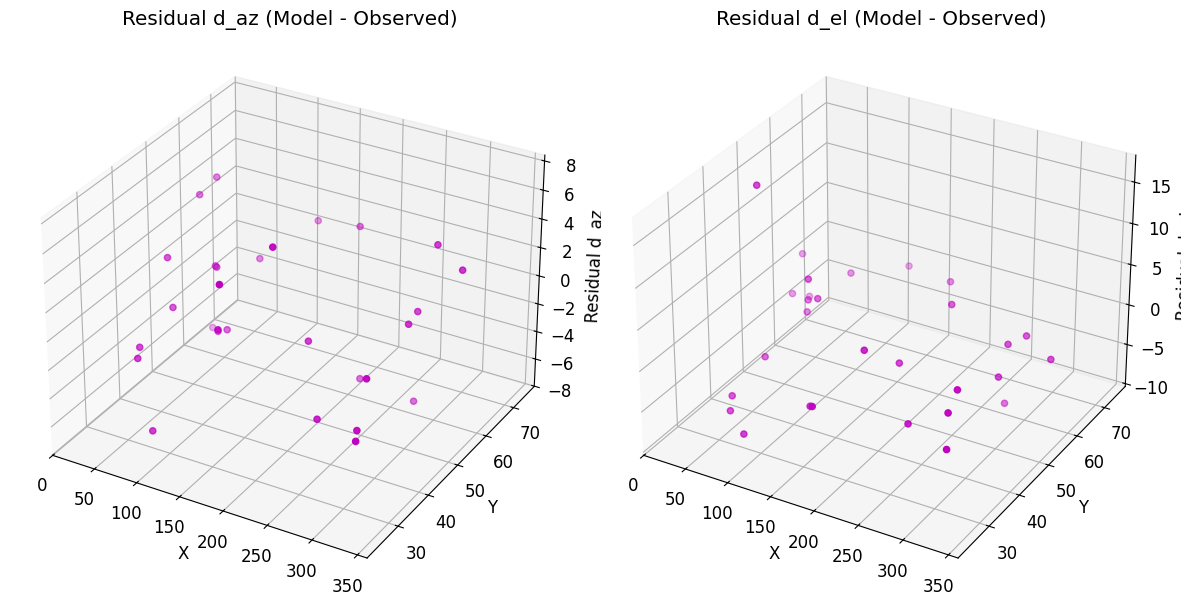

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm  # カラーマップの追加

# データファイルの読み込み
file = "./necst_opticalpointing_20241127_090530Az_El_dAz_dEl.dat"  # before
# file = "./necst_opticalpointing_20241127_094605Az_El_dAz_dEl.dat"  # after

data = pd.read_csv(file, sep=",")

# データの確認
print(data.head())

# x, y, d_az_obs, d_el_obsの抽出
x = data.iloc[:, 0].values  # 列1
y = data.iloc[:, 1].values  # 列2
d_az_obs = data.iloc[:, 2].values  # 列3
d_el_obs = data.iloc[:, 3].values  # 列4

################ 図1 ###############################################################
# 初期データの3Dプロット
plt.rcParams["font.size"] = 12
fig = plt.figure(figsize=(12, 6))

# d_azのプロット
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x, y, d_az_obs, c='r', marker='o', label='Observed d_az')
ax1.set_title('Observed d_az')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('d_az')

# d_elのプロット
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x, y, d_el_obs, c='b', marker='^', label='Observed d_el')
ax2.set_title('Observed d_el')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('d_el')

plt.tight_layout()
plt.show()

# モデル関数の定義
def d_az_model(vars, a1, a2, a3, b1, b2):
    x, y = vars
    y_rad = np.deg2rad(y)
    x_rad = np.deg2rad(x)
    return (a1 * np.sin(y_rad) +
            a2 +
            a3 * np.cos(y_rad) +
            b1 * np.sin(x_rad) * np.sin(y_rad) -
            b2 * np.cos(x_rad) * np.sin(y_rad))

def d_el_model(vars, b1, b2, b3, g1):
    x, y = vars
    x_rad = np.deg2rad(x)
    return (b1 * np.cos(x_rad) +
            b2 * np.sin(x_rad) +
            b3 +
            g1 * y)

# フィッティング: d_el
initial_guess_el = [1, 1, 1, 1]  # 初期推定値
params_el, covariance_el = curve_fit(d_el_model, (x, y), d_el_obs, p0=initial_guess_el)
b1, b2, b3, g1 = params_el
print(f"Fitted parameters for d_el: b1={b1}, b2={b2}, b3={b3}, g1={g1}")

# フィッティング: d_az
initial_guess_az = [1, 1, 1, 1, 1]  # 初期推定値
params_az, covariance_az = curve_fit(d_az_model, (x, y), d_az_obs, p0=initial_guess_az)
a1, a2, a3, b1_az, b2_az = params_az
print(f"Fitted parameters for d_az: a1={a1}, a2={a2}, a3={a3}, b1={b1_az}, b2={b2_az}")

# フィッティング結果のモデル値を計算
d_el_fit = d_el_model((x, y), *params_el)
d_az_fit = d_az_model((x, y), *params_az)

# フィッティング結果のプロット（ワイヤーフレーム表示）
# メッシュグリッドの作成（粗めに設定）
x_grid = np.linspace(np.min(x), np.max(x), 30)  # 30ポイントに減少
y_grid = np.linspace(np.min(y), np.max(y), 30)  # 30ポイントに減少
X, Y = np.meshgrid(x_grid, y_grid)

# フィッティングされた関数をメッシュグリッド上で評価
d_el_mesh = d_el_model((X, Y), *params_el)
d_az_mesh = d_az_model((X, Y), *params_az)

################ 図2 ###############################################################
fig = plt.figure(figsize=(12, 6))
fig.suptitle(file)

# d_azのフィッティング結果
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x, y, d_az_obs, c='r', marker='o', label='observed data')
# ワイヤーフレームの追加
wire_az = ax1.plot_wireframe(X, Y, d_az_mesh, color='g', linewidth=0.5, label='fitted dx')
ax1.set_title('dx fit')
ax1.set_xlabel('Az [deg]')
ax1.set_ylabel('El [deg]')
ax1.set_zlabel('dx [arcsec]')
ax1.view_init(elev=30, azim=225)

# d_elのフィッティング結果
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x, y, d_el_obs, c='b', marker='^', label='observed data')
# ワイヤーフレームの追加
wire_el = ax2.plot_wireframe(X, Y, d_el_mesh, color='g', linewidth=0.5, label='fitted dy')
ax2.set_title('dy fit')
ax2.set_xlabel('Az [deg]')
ax2.set_ylabel('El [deg]')
ax2.set_zlabel('dy [arcsec]')
ax2.view_init(elev=30, azim=225)

# カラーバーの代わりに凡例を追加（plot_wireframeは凡例に対応していないため）
from matplotlib.lines import Line2D

# カスタム凡例の作成
legend_elements_az = [
    Line2D([0], [0], marker='o', color='w', label='observed data',
           markerfacecolor='r', markersize=10),
    Line2D([0], [0], color='g', lw=2, label='fitted dx')
]
ax1.legend(handles=legend_elements_az)

legend_elements_el = [
    Line2D([0], [0], marker='^', color='w', label='observed data',
           markerfacecolor='b', markersize=10),
    Line2D([0], [0], color='g', lw=2, label='fitted dy')
]
ax2.legend(handles=legend_elements_el)

plt.tight_layout()
plt.show()

# 残差の計算
residual_d_az = d_az_fit - d_az_obs
residual_d_el = d_el_fit - d_el_obs

################ 図3 ###############################################################
# 残差のプロット（ワイヤーフレーム表示は不要なので散布図のまま）
fig = plt.figure(figsize=(12, 6))

# d_azの残差
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x, y, residual_d_az, c='m', marker='o')
ax1.set_title('Residual d_az (Model - Observed)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Residual d_az')

# d_elの残差
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x, y, residual_d_el, c='m', marker='o')
ax2.set_title('Residual d_el (Model - Observed)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Residual d_el')

plt.tight_layout()
plt.show()

In [31]:
# time.time=1.73513640e+09をdatetimeに変換
import datetime
time = 1.73513640e+09
dt = datetime.datetime.fromtimestamp(time)
print(dt)

2024-12-25 23:20:00
